# Eluvio Data Science Challenge: Modeling Notebook 2

####Target Variable: "nsfc" (not suitable for children, created in the data wrangling notebook)
####Models: BERT Classification Model & a Stacked Ensemble Model with an XGBoost Classifier

- For this predictive model, our target variable is "nsfc", the feature we created to better capture all content "Not Suitable For Children", because the original "over_18" seemed insufficient. 
- Given that the dataset set is so large and imbalanced, we will use random undersampling to significantly undersample the majority class to achieve an 80/20 ratio. For this model, we had success with a smaller max length for the text input into the BERT encoder of 50 characters. 
- The metric we are optimizing for is recall, given the class imbalance of our target variable. Utilizing only the BERT model yielded a recall score of 97% and with the stacked XGBoost model we achieved a recall score of 98%. Depending on the business applications of this model, the stacked model approach could prove worth the additional compute resources required.


In [3]:
!pip install sentencepiece
#!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_curve,auc
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from datetime import datetime
import time
import tensorflow as tf
import keras
import tensorflow_hub as hub
import logging

logging.basicConfig(level=logging.INFO)

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Eluvio_Challenge/')

import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print('\nGPU:\n', gpu_info)

Mounted at /content/drive
     |████████████████████████████████| 1.2MB 5.9MB/s 
     |████████████████████████████████| 112kB 5.9MB/s 


INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2, Total size: 421.50MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.



GPU:
 Tue Apr 20 06:52:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    39W / 300W |   1455MiB / 16160MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [4]:
data = pd.read_csv('data/Eluvio_DS_Challenge_cleaned_wrangled.csv', index_col=0)

In [5]:
data.head(5)

,time_created,up_votes,title,over_18,author,clock_time,hour,day_of_week,month,year,hour_period,season,nsfc,char_count,word_count,flesch_readability,flesch_grade
0,2008-01-25 03:34:06,3,Scores killed in Pakistan clashes,False,polar,03:34:06,3,4,1,2008,Late_Night,Q1,True,33,5,83.32,2.9
1,2008-01-25 03:34:35,2,Japan resumes refuelling mission,False,polar,03:34:35,3,4,1,2008,Late_Night,Q1,False,32,4,33.58,9.6
2,2008-01-25 03:42:03,3,US presses Egypt on Gaza border,False,polar,03:42:03,3,4,1,2008,Late_Night,Q1,False,31,6,90.77,2.1
3,2008-01-25 03:54:50,1,Jump-start economy: Give health care to all,False,fadi420,03:54:50,3,4,1,2008,Late_Night,Q1,False,44,7,64.37,6.0
4,2008-01-25 15:25:20,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,15:25:20,15,4,1,2008,Noon,Q1,False,47,7,38.99,9.6


In [6]:
data.shape

(509236, 17)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509236 entries, 0 to 509235
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   time_created        509236 non-null  object 
 1   up_votes            509236 non-null  int64  
 2   title               509236 non-null  object 
 3   over_18             509236 non-null  bool   
 4   author              509236 non-null  object 
 5   clock_time          509236 non-null  object 
 6   hour                509236 non-null  int64  
 7   day_of_week         509236 non-null  int64  
 8   month               509236 non-null  int64  
 9   year                509236 non-null  int64  
 10  hour_period         509236 non-null  object 
 11  season              509236 non-null  object 
 12  nsfc                509236 non-null  bool   
 13  char_count          509236 non-null  int64  
 14  word_count          509236 non-null  int64  
 15  flesch_readability  509236 non-nul

### Feature Engineering
For all the model except for the Bert Model, we will use a TF-IDF Vectorizer to convert the "title" column into tokens.

In [8]:
data.nsfc.value_counts()

False    471608
True      37628
Name: nsfc, dtype: int64

In [9]:
train,test =train_test_split(data,test_size = 0.15, random_state=42)

In [10]:
print(train.shape)
test.shape

(432850, 17)


(76386, 17)

In [11]:
train.nsfc.value_counts()

False    400882
True      31968
Name: nsfc, dtype: int64

In [12]:
test.nsfc.value_counts()

False    70726
True      5660
Name: nsfc, dtype: int64

### Random Undersampling 
- Undersampling Majority/Minority Classes of the "nsfc" variable for an 80/20 ratio to address class imbalances as well as the create a smaller training dataset to less GPU usage requirements.

In [13]:
train_majority_class = train[train.nsfc==False]
train_minority_class = train[train.nsfc==True]

train_majority_class = train_majority_class.sample(n=10000)
train_minority_class = train_minority_class.sample(n=2000)

train = pd.concat([train_majority_class,train_minority_class]).sort_index()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [14]:
train.nsfc.value_counts()

False    10000
True      2000
Name: nsfc, dtype: int64

In [15]:
test_majority_class = test[test.nsfc==False]
test_minority_class = test[test.nsfc==True]
test_majority_class = test_majority_class.sample(n=5000)
test_minority_class = test_minority_class.sample(n=2000)


test = pd.concat([test_majority_class,test_minority_class]).sort_index()

In [16]:
test.nsfc.value_counts() 

False    5000
True     2000
Name: nsfc, dtype: int64

In [17]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [18]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [19]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(2, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
start = time.time()

max_len = 50
train_input = bert_encode(train.title.values, tokenizer, max_len=max_len)
train_labels = keras.utils.to_categorical(train.nsfc.values, num_classes=2)

stop = time.time()
print(stop-start)

4.314789772033691


In [22]:

model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [23]:
# file_path/name for saved models
model_folder = '/content/drive/MyDrive/Eluvio_Challenge/data/'
mode_name = 'bert_model_nsfc_1.h5'
file_path = model_folder+ mode_name

checkpoint = tf.keras.callbacks.ModelCheckpoint(file_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1)


Epoch 1/10
300/300 [==============================] - 52s 125ms/step - loss: 0.3481 - accuracy: 0.8650 - val_loss: 0.0500 - val_accuracy: 0.9904

Epoch 00001: val_loss improved from inf to 0.04996, saving model to /content/drive/MyDrive/Eluvio_Challenge/data/bert_model_nsfc_1.h5
Epoch 2/10
300/300 [==============================] - 37s 123ms/step - loss: 0.0566 - accuracy: 0.9916 - val_loss: 0.0381 - val_accuracy: 0.9937

Epoch 00002: val_loss improved from 0.04996 to 0.03814, saving model to /content/drive/MyDrive/Eluvio_Challenge/data/bert_model_nsfc_1.h5
Epoch 3/10
300/300 [==============================] - 37s 123ms/step - loss: 0.0389 - accuracy: 0.9946 - val_loss: 0.0398 - val_accuracy: 0.9942

Epoch 00003: val_loss did not improve from 0.03814
Epoch 4/10
300/300 [==============================] - 37s 122ms/step - loss: 0.0257 - accuracy: 0.9950 - val_loss: 0.0324 - val_accuracy: 0.9937

Epoch 00004: val_loss improved from 0.03814 to 0.03240, saving model to /content/drive/MyDriv

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


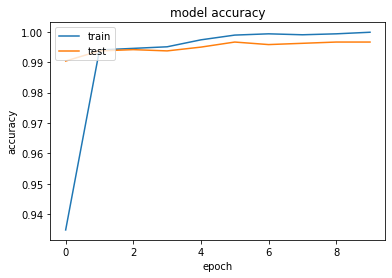

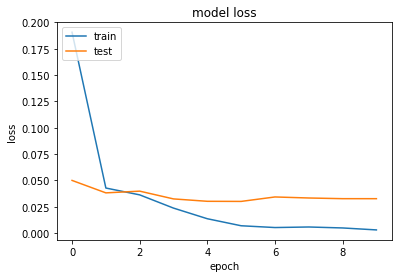

In [24]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loading Saved Model

In [20]:
# Loading Saved Model Weights
saved_model_folder = "/content/drive/MyDrive/Eluvio_Challenge/data/"
model_name = 'bert_model_nsfc_1.h5'
file_path = saved_model_folder + model_name
max_len = 50

model = build_model(bert_layer, max_len=max_len)
model.load_weights(file_path)

In [21]:
%%time

test_input = bert_encode(test.title.values, tokenizer, max_len=max_len)
test_labels = keras.utils.to_categorical(test.over_18.values, num_classes=2)

test_pred = model.predict(test_input)

test_pred = test_pred.argmax(1)
test_true = test.nsfc

CPU times: user 5.61 s, sys: 397 ms, total: 6.01 s
Wall time: 12.1 s


              precision    recall  f1-score   support

       False       0.99      1.00      0.99      5000
        True       1.00      0.97      0.98      2000

    accuracy                           0.99      7000
   macro avg       0.99      0.98      0.99      7000
weighted avg       0.99      0.99      0.99      7000



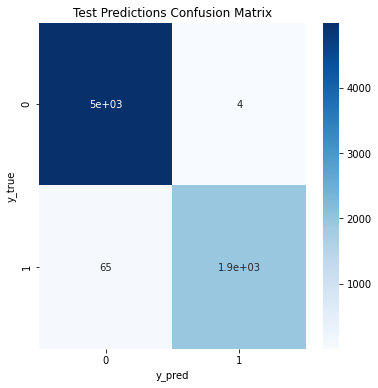

In [23]:
print(classification_report(test_true, test_pred))

plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(test_true, test_pred), annot=True, cmap="Blues")
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title("Test Predictions Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(test_true, test_pred, drop_intermediate=False)
auc_ = auc(fpr, tpr)

### Stacked Model (Output of BERT As Input into Random Forest Model)
take predictions from BERT and use as inputs in Random Forest Model.
(train the model with BERT preds, then predict on test data?

In [28]:
%%time 

train_pred = model.predict(train_input)
train_pred = train_pred.argmax(1)

CPU times: user 5.2 s, sys: 623 ms, total: 5.83 s
Wall time: 13.6 s


In [31]:
%%time 

train_ =train.copy()
test_ = test.copy()

train_['bert_preds'] = train_pred
test_['bert_preds'] = test_pred

train_ = train_.drop(columns=['author','title','time_created','clock_time'])
test_ = test_.drop(columns=['author','title','time_created','clock_time'])

X_train = train_.drop(columns=['nsfc'])
y_train = train_.nsfc

X_test = test_.drop(columns=['nsfc'])
y_test = test_.nsfc

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# # fit model with training data
# xgb_model = XGBClassifier()
# xgb_model.fit(X_train, y_train)
# # make predictions for test data
# y_pred = xgb_model.predict(X_test)

CPU times: user 32.6 ms, sys: 16.5 ms, total: 49 ms
Wall time: 51.2 ms


In [32]:
%%time

# grid search
xgb_model = XGBClassifier()
n_estimators = [50, 100, 200, 300, 400]
learning_rate = [0.00001, 0.0001, 0.001, 0.01]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
xgb_grid_search = GridSearchCV(xgb_model, param_grid, scoring="recall", n_jobs=-1, cv=kfold)

xgb_grid_result = xgb_grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (xgb_grid_result.best_score_, xgb_grid_result.best_params_))

# make predictions for test data using best model
y_pred = xgb_grid_result.predict(X_test)

Best: 0.996000 using {'learning_rate': 1e-05, 'n_estimators': 50}
CPU times: user 3.08 s, sys: 377 ms, total: 3.45 s
Wall time: 2min 31s


              precision    recall  f1-score   support

       False       0.99      1.00      1.00      5000
        True       1.00      0.98      0.99      2000

    accuracy                           0.99      7000
   macro avg       1.00      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000



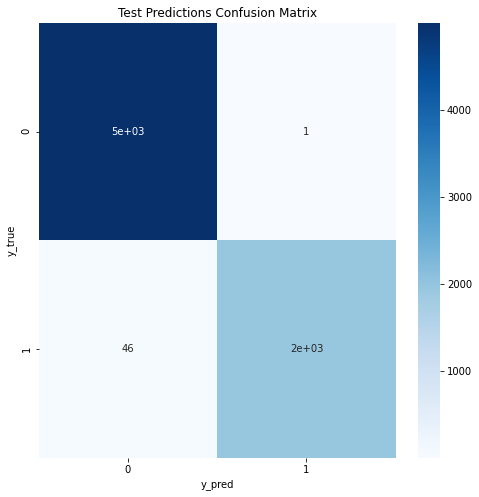

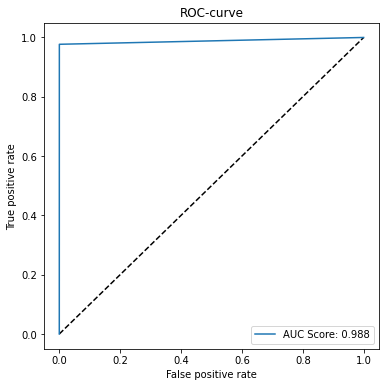

In [33]:
# Calculate the accuracy score: score
score = classification_report(y_test, y_pred)
print(score)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title("Test Predictions Confusion Matrix")
plt.show()

# calculating prediction probabilities on test set for roc_curve
y_pred_ = xgb_grid_result.predict_proba(X_test)
y_pred_ = pd.Series(list(y_pred_)).apply(lambda x: x[1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_,drop_intermediate=False)
auc_ = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC Score: {:.3f}'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-curve')
plt.legend(loc='best')
plt.show()

In [34]:
# saving dataframe and model

data_ = pd.concat([train_,test_])
data.to_csv('data/df_with_bert_nsfc_feature.csv')

# save model to file
pickle.dump(xgb_model, open("./data/xgb_model_with_bert_nsfc_feature.pkl", "wb"))